In [418]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torchinfo
from torchviz import make_dot

from torch.autograd import Variable

In [419]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [665]:
symbol = 'GOOGL'
df = pd.read_csv(f'stock_data/{symbol}.csv',index_col=0, header=0, parse_dates=True)

In [666]:
# symbol_us = 'BABA'
# symbol_other = '9988.HK'
# df = pd.read_csv(f'stock_data/{symbol_us}.csv',header=0, index_col=0, parse_dates=True)
# df_other = pd.read_csv(f'stock_data/{symbol_other}.csv',header=0, index_col=0, parse_dates=True)

In [667]:
#Preprocess1
from sklearn import preprocessing
n = int(len(df)*.7)
data = df.values
labels = df['Open'].values.reshape(-1,1) # Open value of Tomorrow

data_normalizer = preprocessing.StandardScaler()
data_train = data_normalizer.fit_transform(data[:n])

labels_normalizer = preprocessing.StandardScaler()
labels_train = labels_normalizer.fit_transform(labels[:n])

data_test = data_normalizer.fit_transform(data[n:,])

labels_test = labels_normalizer.fit_transform(labels[n:,])
labels.shape

(4113, 1)

In [668]:
#Preprocess2: Create n_days time-steps to feed to LSTM

def pre_process(data,labels,n_days):
    if n_days <1:
        raise Exception("n_days should be 1 or more")
        
    labels = labels[n_days:]
    data_n_days = np.array([data[i-n_days:i,] for i in range(n_days,len(data))])
    return data_n_days, labels

n_days = 1
data_train, labels_train = pre_process(data_train,labels_train,n_days)
data_test, labels_test = pre_process(data_test,labels_test,n_days)
print(f'data_train:{data_train.shape},labels_train:{labels_train.shape}')
print(f'data_test:{data_test.shape},labels_test:{labels_test.shape}')

index_labels_train = df.index[n_days:n]
index_labels_test = df.index[n+n_days:]
len(index_labels_test)

data_train:(2878, 1, 6),labels_train:(2878, 1)
data_test:(1233, 1, 6),labels_test:(1233, 1)


1233

In [669]:
data_train = torch.tensor(data_train,device=device)
labels_train = torch.tensor(labels_train,device=device)

data_test = torch.tensor(data_test,device=device)
labels_test = torch.tensor(labels_test,device=device)

print(f'data_train:{data_train.shape},labels_train:{labels_train.shape}')
print(f'data_test:{data_test.shape},labels_test:{labels_test.shape}')


data_train:torch.Size([2878, 1, 6]),labels_train:torch.Size([2878, 1])
data_test:torch.Size([1233, 1, 6]),labels_test:torch.Size([1233, 1])


In [670]:
class Stock_lstm(nn.Module):
    def __init__(self,input_features,hidden_features,num_layers, n_days):
        super(Stock_lstm,self).__init__()
        self.input_features = input_features
        self.hidden_features = hidden_features
        self.num_layers = num_layers
        self.n_days = n_days, #or time_step
        
        self.lstm = nn.LSTM(input_features,hidden_features,num_layers,batch_first = True)
        self.fc_1 = nn.Linear(hidden_features*n_days,128)
        self.fc_2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self,x):
       # input.shape: (batch,n_days,input_features)
       # h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
       # c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
        
        x, _ = self.lstm(x) # output.shape: (batch,n_days,output_features)
        x = x.reshape(x.shape[0],-1) # output.shape: (batch,n_days*output_features)
        x= self.fc_1(x)
        x = self.relu(x)
        x = self.fc_2(x)
        return x

In [693]:
epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_features = 6 #number of features
hidden_features = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
batch_size = data_train.shape[0]

stock_lstm = Stock_lstm(input_features,hidden_features,num_layers,n_days) #our lstm class 
stock_lstm.to(device)
torchinfo.summary(stock_lstm,(batch_size, n_days, input_features))

Layer (type:depth-idx)                   Output Shape              Param #
Stock_lstm                               --                        --
├─LSTM: 1-1                              [2878, 1, 2]              80
├─Linear: 1-2                            [2878, 128]               384
├─ReLU: 1-3                              [2878, 128]               --
├─Linear: 1-4                            [2878, 1]                 129
Total params: 593
Trainable params: 593
Non-trainable params: 0
Total mult-adds (M): 1.71
Input size (MB): 0.07
Forward/backward pass size (MB): 3.02
Params size (MB): 0.00
Estimated Total Size (MB): 3.09

In [694]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(stock_lstm.parameters(), lr=1e-3) 
for epoch in range(50001):  
    outputs = stock_lstm.forward(data_train.float())
    optimizer.zero_grad()

    loss = criterion(outputs,labels_train.float())
    loss.backward()
    optimizer.step()
    if epoch%1000==0:
        print(f'Epoch:{epoch},  loss:{loss.item()}')
        

Epoch:0,  loss:1.0512977838516235
Epoch:1000,  loss:0.001162216765806079
Epoch:2000,  loss:0.0008157167467288673
Epoch:3000,  loss:0.0007173824706114829
Epoch:4000,  loss:0.0006703290273435414
Epoch:5000,  loss:0.0006472954410128295
Epoch:6000,  loss:0.000629895890597254
Epoch:7000,  loss:0.0006200032075867057
Epoch:8000,  loss:0.0006090222159400582
Epoch:9000,  loss:0.0006030987133271992
Epoch:10000,  loss:0.0006002991576679051
Epoch:11000,  loss:0.0005970963393338025
Epoch:12000,  loss:0.0005954075022600591
Epoch:13000,  loss:0.0006052260869182646
Epoch:14000,  loss:0.0005941827548667789
Epoch:15000,  loss:0.0005940318224020302
Epoch:16000,  loss:0.0005956505774520338
Epoch:17000,  loss:0.0005920058465562761
Epoch:18000,  loss:0.0005961425486020744
Epoch:19000,  loss:0.0005914061912335455
Epoch:20000,  loss:0.000590883253607899
Epoch:21000,  loss:0.0005920884432271123
Epoch:22000,  loss:0.000592241995036602
Epoch:23000,  loss:0.0005953499930910766
Epoch:24000,  loss:0.000590734067372

In [695]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(stock_lstm.parameters(), lr=1e-4) 
for epoch in range(50001):  
    outputs = stock_lstm.forward(data_train.float())
    optimizer.zero_grad()

    loss = criterion(outputs,labels_train.float())
    loss.backward()
    optimizer.step()
    if epoch%1000==0:
        print(f'Epoch:{epoch},  loss:{loss.item()}')

Epoch:0,  loss:0.0005840032827109098
Epoch:1000,  loss:0.0005842781974934042
Epoch:2000,  loss:0.000583705201279372
Epoch:3000,  loss:0.0005835597985424101
Epoch:4000,  loss:0.0005835106712765992
Epoch:5000,  loss:0.0005834851763211191
Epoch:6000,  loss:0.0005838115466758609
Epoch:7000,  loss:0.0005837829667143524
Epoch:8000,  loss:0.0005833832547068596
Epoch:9000,  loss:0.0005833319155499339
Epoch:10000,  loss:0.0005832706810906529
Epoch:11000,  loss:0.0005832270253449678
Epoch:12000,  loss:0.000583201996050775
Epoch:13000,  loss:0.0005831554881297052
Epoch:14000,  loss:0.0005833840696141124
Epoch:15000,  loss:0.0005830866866745055
Epoch:16000,  loss:0.0005831667222082615
Epoch:17000,  loss:0.0005830269656144083
Epoch:18000,  loss:0.0005832791794091463
Epoch:19000,  loss:0.0005829635774716735
Epoch:20000,  loss:0.0005833731265738606
Epoch:21000,  loss:0.0005828308640047908
Epoch:22000,  loss:0.0005826862179674208
Epoch:23000,  loss:0.0005827477434650064
Epoch:24000,  loss:0.0005833229

In [696]:
with torch.no_grad():
    outputs = stock_lstm(data_test.float())

results = labels_normalizer.inverse_transform(outputs.cpu())
results = pd.DataFrame(results, index=index_labels_test,columns=['Prediction'])
results['Target'] = labels_normalizer.inverse_transform(labels_test.cpu())

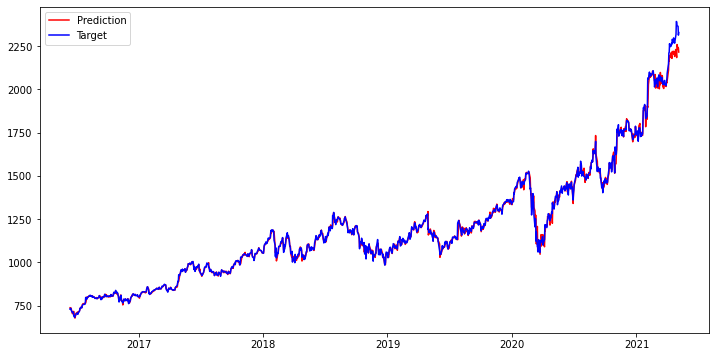

In [713]:
plt.figure(figsize=(12,6))
plt.plot(results['Prediction'],'r')
plt.plot(results['Target'],'b')
plt.legend(['Prediction', 'Target'])

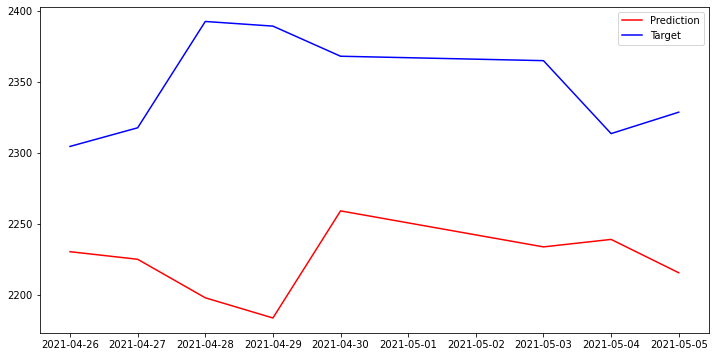

In [711]:
plt.figure(figsize=(12,6))
plt.plot(results.loc['2021-04-25':]['Prediction'],'r')
plt.plot(results.loc['2021-04-25':]['Target'],'b')
plt.legend(['Prediction', 'Target'])

In [702]:
mse = np.sum((results['Target']-results['Prediction'])**2,axis=0)/len(results['Target'])
r_squared = 1-np.sum((results['Target']-results['Prediction'])**2,axis=0)/np.sum((results['Target']-results['Target'].mean())**2,axis=0)
print(f'Open Prediction: \n MSE: {mse}, R-Squared: {r_squared}')

Open Prediction: 
 MSE: 398.01169090599456, R-Squared: 0.9964943558349839


In [712]:
mse = np.sum((results['Target'].loc['2021-04-25':]-results['Prediction'].loc['2021-04-25':])**2,axis=0)/len(results['Target'].loc['2021-04-25':])
r_squared = 1-(np.sum((results['Target'].loc['2021-04-25':]-results['Prediction'].loc['2021-04-25':])**2,axis=0)/np.sum((results['Target'].loc['2021-04-25':]-results['Target'].loc['2021-04-25':].mean())**2,axis=0))

print(f'Open Prediction from 2021-04-25 to 2021-05-24: \n: \n MSE: {mse}, R-Squared: {r_squared}')

Open Prediction from 2021-04-25 to 2021-05-24: 
: 
 MSE: 17689.157327727247, R-Squared: -15.193999799336385


In [707]:
np.sum((results['Target'].loc['2021-04-27':].values-results['Target'].loc['2021-04-26':'2021-05-04'].values)**2,axis=0)

9112.868054092463

In [710]:
np.sum((results['Target'].loc['2021-04-27':]-results['Prediction'].loc['2021-04-27':])**2,axis=0)

136021.05908944982

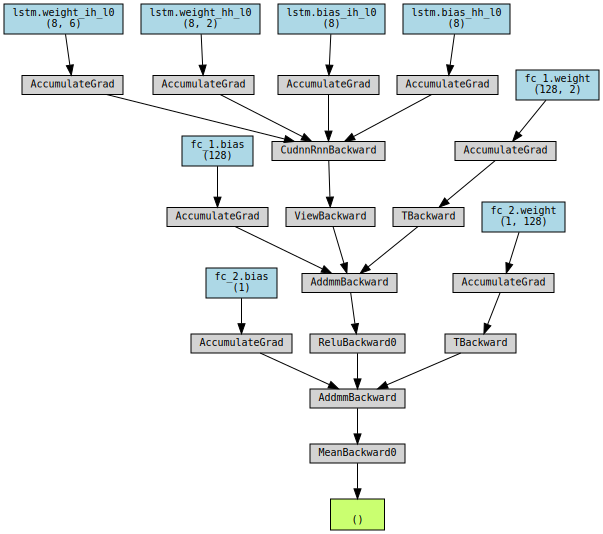

In [613]:
outputs = stock_lstm(data_train.float())

make_dot(outputs.mean(),params=dict(stock_lstm.named_parameters()))